# Non-linear Breit-Wheeler pair creation

In [1]:
import numpy as np
import scipy.special as spe
import scipy.integrate as integ
import matplotlib.pyplot as plt


In [2]:
me = 9.1093837015e-31
hbar = 1.054571817e-34
qe = 1.602176634e-19
c = 299792458
fine_structure = 0.0072973525693


E_s = (me**2 * c**3)/(qe * hbar)
print(E_s)

1.323285474948166e+18


In [3]:
def calc_chi_gamma(p, E, B):
    gamma_phot = np.linalg.norm(p,axis=1)  
    c = p/gamma_phot[:,None]
    cdotE = np.einsum('ij,ij->i',c,E)
    ccrossB = np.cross(c,B)
    loc_field = gamma_phot * np.linalg.norm( E - cdotE[:,None]*c + ccrossB, axis=1)     
    return loc_field/schwinger_field_code_units

In [4]:
@np.vectorize
def inner(x):
    return integ.quad(lambda s: np.sqrt(s)*spe.kv(1./3., 2./3. * s**(3./2.)), x, np.inf)[0] 

def X(chi_phot, chi_ele):
    res = np.zeros(np.shape(chi_phot))
    div = (chi_ele*(chi_phot-chi_ele))
    div = np.where(np.logical_and(chi_phot > chi_ele, chi_ele != 0), div, 1.0);
    res = np.where(np.logical_and(chi_phot > chi_ele, chi_ele != 0), np.power(chi_phot/div, 2./3.), np.inf)
    return res

def Tinteg(chi_phot, chi_ele):
    return inner(X(chi_phot, chi_ele)) - (2.0 - chi_phot*np.power(X(chi_phot, chi_ele), 3./2.))*spe.kv(2./3., 2./3. *X(chi_phot, chi_ele)**(3./2.)) 
    
@np.vectorize
def T(chi_phot):
    coeff = 1./(np.pi * np.sqrt(3.) * (chi_phot**2))
    return coeff*integ.quad(lambda chi_ele: Tinteg(chi_phot, chi_ele), 0, chi_phot)[0] 

coeff_BW = fine_structure * me*c**2/hbar 
def dNBW_dt(chi_phot, e_phot):
    return coeff_BW*T(chi_phot)*(chi_phot/e_phot)

@np.vectorize
def P(chi_phot, chi_ele):
    return integ.quad(lambda chi_ele: dNBW_dt ,0, chi_phot)[0] 

In [5]:
dNBW_dt(1,1)

8.008267283863469e+16

## Visualize results

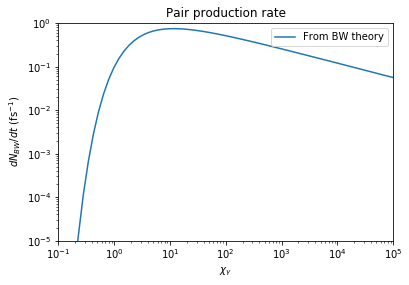

In [97]:
NUM = 100
px = np.logspace(-1, 8.0, num=NUM, base=10)
P = np.zeros([NUM,3])
E = np.zeros([NUM,3])
B = np.zeros([NUM,3])
P[:,0] = px
E[:,1] = 500
chi = calc_chi_gamma(P,E,B)
en = px

dNBW = dNBW_dt(chi,en)

plt.loglog(chi, dNBW*1e-15, label='From BW theory')
plt.xlabel('$\chi_{\gamma}$')
plt.ylabel('$dN_{BW}/dt$ (fs$^{-1}$)')
plt.title('Pair production rate')
plt.legend()
plt.ylim(1e-5, 1)
plt.xlim(1e-1,1e5)
plt.show()

In [108]:
NUM_frac = 50

chi_gamma = np.array([0.01, 0.1, 1.0, 10.0, 100.0, 1000.0])
cumulative_prob = np.zeros([6,NUM_frac])
frac = np.linspace(0, 1.0, NUM_frac)

for i in range(6):
    den = integ.quad(lambda x: Tinteg(chi_gamma[i], x), 0, chi_gamma[i])[0]
    cumulative_prob[i,0] = 0.0
    for j in range(1,NUM_frac-1):
        cumulative_prob[i,j] = integ.quad(lambda x: Tinteg(chi_gamma[i], x), 0, frac[j]*chi_gamma[i])[0]/den
    cumulative_prob[i,-1] = 1.0

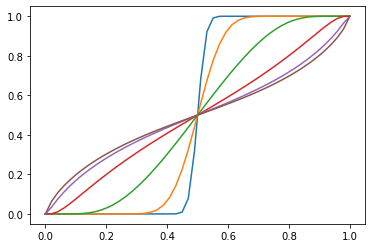

In [110]:
for i in range(6):
    plt.plot(frac, cumulative_prob[i])


In [118]:
NUM_frac = 100

chi_gamma = np.array([0.01, 0.1, 1.0, 10.0, 100.0, 1000.0])
prob = np.zeros([6,NUM_frac])
frac = np.linspace(0, 1.0, NUM_frac)

for i in range(6):
    den = integ.quad(lambda x: Tinteg(chi_gamma[i], x), 0, chi_gamma[i])[0]
    for j in range(0,NUM_frac):
        prob[i,j] = Tinteg(chi_gamma[i], frac[j]*chi_gamma[i])*((frac[1]-frac[0])*chi_gamma[i])/den

<ipython-input-95-73bb124e881b>:3: RuntimeWarning: invalid value encountered in double_scalars
  return integ.quad(lambda s: np.sqrt(s)*spe.kv(1./3., 2./3. * s**(3./2.)), x, np.inf)[0]
<ipython-input-95-73bb124e881b>:3: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integ.quad(lambda s: np.sqrt(s)*spe.kv(1./3., 2./3. * s**(3./2.)), x, np.inf)[0]
<ipython-input-95-73bb124e881b>:13: RuntimeWarning: invalid value encountered in double_scalars
  return inner(X(chi_phot, chi_ele)) - (2.0 - chi_phot*np.power(X(chi_phot, chi_ele), 3./2.))*spe.kv(2./3., 2./3. *X(chi_phot, chi_ele)**(3./2.))


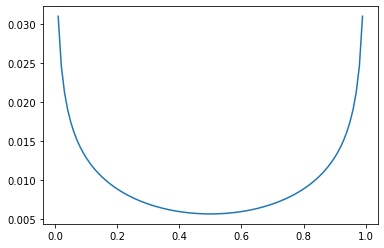

In [122]:
#for i in range(6):
#    plt.plot(frac, prob[i])

plt.plot(frac, prob[5])